In [ ]:
# Data processing
# ==============================================================================
# Instalación de librerías necesarias
!pip install -q astral session-info numpy pandas matplotlib plotly xgboost lightgbm catboost scikit-learn shap feature-engine skforecast
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import xgboost
import lightgbm
import catboost
import sklearn
import shap
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

import skforecast
from skforecast.recursive import ForecasterEquivalentDate
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, OneStepAheadFold
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.feature_selection import select_features

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión lightgbm: {lightgbm.__version__}")
print(f"{color}Versión xgboost: {xgboost.__version__}")
print(f"{color}Versión catboost: {catboost.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




Versión skforecast: 0.14.0
Versión scikit-learn: 1.5.2
Versión lightgbm: 4.5.0
Versión xgboost: 2.1.3
Versión catboost: 1.2.7
Versión pandas: 2.2.2
Versión numpy: 1.26.4


In [ ]:
datos = pd.read_excel('/content/datos_economia.xlsx')

In [ ]:
# Preprocesado de datos (estableciendo índice y frecuencia)
# ==============================================================================
datos = datos[['date_time', 'users', 'holiday', 'weather', 'temp', 'atemp', 'hum', 'windspeed']]
datos['date_time'] = pd.to_datetime(datos['date_time'], format='%Y-%m-%d %H:%M:%S')
datos = datos.set_index('date_time')
if pd.__version__ < '2.2':
    datos = datos.asfreq('H')
else:
    datos = datos.asfreq('h')
datos = datos.sort_index()
datos.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: Imp

users  holiday weather  temp   atemp   hum  windspeed
date_time                                                                 
2011-01-01 00:00:00   16.0      0.0   clear  9.84  14.395  81.0        0.0
2011-01-01 01:00:00   40.0      0.0   clear  9.02  13.635  80.0        0.0
2011-01-01 02:00:00   32.0      0.0   clear  9.02  13.635  80.0        0.0
2011-01-01 03:00:00   13.0      0.0   clear  9.84  14.395  75.0        0.0
2011-01-01 04:00:00    1.0      0.0   clear  9.84  14.395  75.0        0.0

In [ ]:
# Separación de datos en entrenamiento, validación y test
# ==============================================================================
fin_train = '2012-04-30 23:59:00'
fin_validacion = '2012-08-31 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]
print(
    f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  "
    f"(n={len(datos_train)})"
)
print(
    f"Fechas validación : {datos_val.index.min()} --- {datos_val.index.max()}  "
    f"(n={len(datos_val)})"
)
print(
    f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  "
    f"(n={len(datos_test)})"
)

Fechas train      : 2011-01-01 00:00:00 --- 2012-04-30 23:00:00  (n=11664)
Fechas validación : 2012-05-01 00:00:00 --- 2012-08-31 23:00:00  (n=2952)
Fechas test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Gráfico interactivo de la serie temporal
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=datos_train.index, y=datos_train['users'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=datos_val.index, y=datos_val['users'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=datos_test.index, y=datos_test['users'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Número de usuarios',
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    legend_title="Partición:",
    width=750,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: Imp

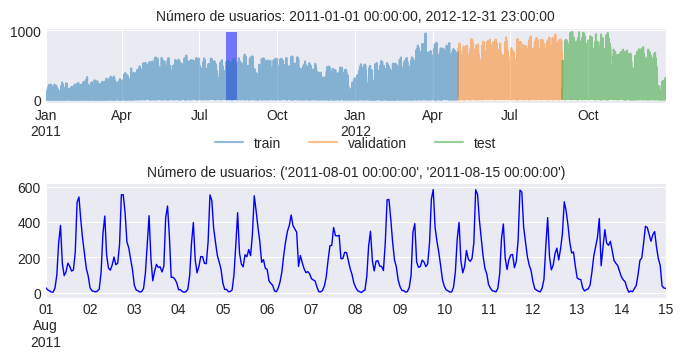

In [ ]:
# Gráfico de la serie temporal con zoom
# ==============================================================================
zoom = ('2011-08-01 00:00:00','2011-08-15 00:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.1, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos_train['users'].plot(ax=main_ax, label='train', alpha=0.5)
datos_val['users'].plot(ax=main_ax, label='validation', alpha=0.5)
datos_test['users'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(datos['users'])
max_y = max(datos['users'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))
datos.loc[zoom[0]: zoom[1]]['users'].plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Número de usuarios: {datos.index.min()}, {datos.index.max()}', fontsize=10)
zoom_ax.set_title(f'Número de usuarios: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



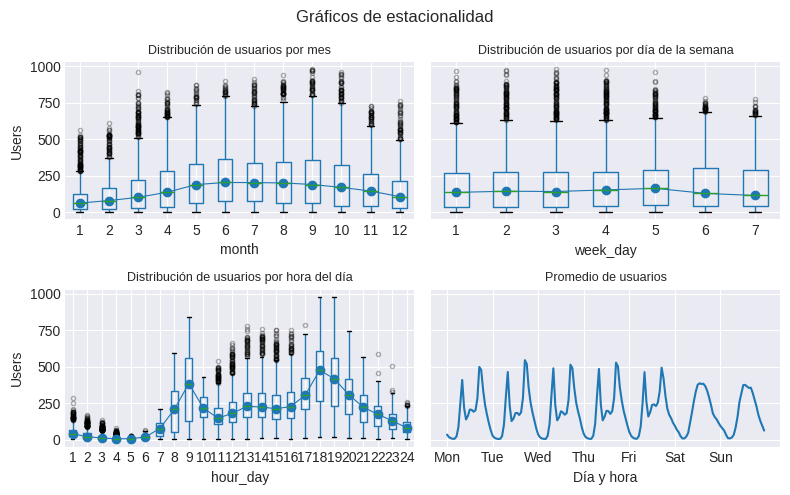

In [ ]:
# Estacionalidad anual, semanal y diaria
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Distribusión de usuarios por mes
datos['month'] = datos.index.month
datos.boxplot(column='users', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
datos.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Users')
axs[0].set_title('Distribución de usuarios por mes', fontsize=9)

# Distribusión de usuarios por día de la semana
datos['week_day'] = datos.index.day_of_week + 1
datos.boxplot(column='users', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
datos.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Users')
axs[1].set_title('Distribución de usuarios por día de la semana', fontsize=9)

# Distribusión de usuarios por hora del día
datos['hour_day'] = datos.index.hour + 1
datos.boxplot(column='users', by='hour_day', ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
datos.groupby('hour_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Users')
axs[2].set_title('Distribución de usuarios por hora del día', fontsize=9)

# Distribusión de usuarios por día de la semana y hora del día
mean_day_hour = datos.groupby(["week_day", "hour_day"])["users"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Promedio de usuarios",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Día y hora",
    ylabel      = "Users"
)
axs[3].title.set_size(9)

fig.suptitle("Gráficos de estacionalidad", fontsize=12)
fig.tight_layout()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



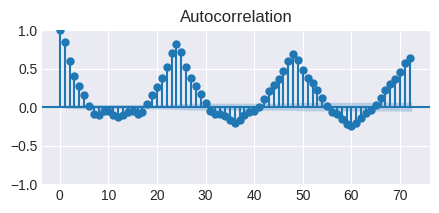

In [ ]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(datos['users'], ax=ax, lags=72)
plt.show()

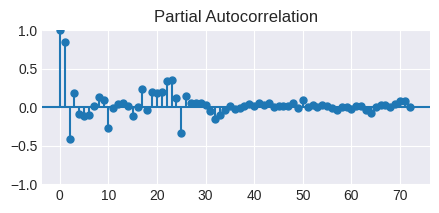

In [ ]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(datos['users'], ax=ax, lags=72, method='ywm')
plt.show()

In [ ]:
# Crear un baseline: valor de la misma hora del día anterior
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                offset    = pd.DateOffset(days=1),
                n_offsets = 1
             )

# Entremaiento del forecaster
# ==============================================================================
forecaster.fit(y=datos.loc[:fin_validacion, 'users'])
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Creation date: 2024-12-15 14:02:43 
Last fit date: 2024-12-15 14:02:43 
Skforecast version: 0.14.0 
Python version: 3.10.12 
Forecaster id: None 

In [ ]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos.loc[:fin_validacion]),
        refit              = False,
)
metrica_baseline, predicciones = backtesting_forecaster(
                                    forecaster    = forecaster,
                                    y             = datos['users'],
                                    cv            = cv,
                                    metric        = 'mean_absolute_error',
                                    n_jobs        = 'auto',
                                    verbose       = False,
                                    show_progress = True
                                )
metrica_baseline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/82 [00:00<?, ?it/s]

mean_absolute_error
0            91.668716

In [ ]:
# Crear el forecaster
# ==============================================================================
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                lags            = 24,
                window_features = window_features
             )

# Entrenar el forecaster
# ==============================================================================
forecaster.fit(y=datos.loc[:fin_validacion, 'users'])
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_72'] 
Window size: 72 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-12-15 14:02:46 
Last fit date: 2024-12-15 14:02:48 
Skforecast version: 0.14.0 
Python version: 3.10.12 
Forecaster id: None

In [ ]:
# Predicciones
# ==============================================================================
forecaster.predict(steps=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: Imp

2012-09-01 00:00:00    108.331027
2012-09-01 01:00:00     68.562982
2012-09-01 02:00:00     33.499525
2012-09-01 03:00:00     10.027583
2012-09-01 04:00:00      3.037563
2012-09-01 05:00:00     17.162543
2012-09-01 06:00:00     51.059825
2012-09-01 07:00:00    146.940053
2012-09-01 08:00:00    344.320596
2012-09-01 09:00:00    439.738683
Freq: h, Name: pred, dtype: float64

In [ ]:
# Backtest del modelo con lo datos de test
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos.loc[:fin_validacion]),
        refit              = False,
     )
metrica, predicciones = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = datos['users'],
                            cv            = cv,
                            metric        = 'mean_absolute_error',
                            n_jobs        = 'auto',
                            verbose       = False,  # Cambiar a True para mostrar más información
                            show_progress = True
                        )
predicciones.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/82 [00:00<?, ?it/s]

pred
2012-09-01 00:00:00  108.331027
2012-09-01 01:00:00   68.562982
2012-09-01 02:00:00   33.499525
2012-09-01 03:00:00   10.027583
2012-09-01 04:00:00    3.037563

In [ ]:
# Error de backtest
# ==============================================================================
metrica

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



mean_absolute_error
0            76.464247

In [ ]:
# Búsqueda de hiperparámetros
# ==============================================================================
# Lags candidatos
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

# Particiones de entrenamiento y validación
cv = TimeSeriesFold(
            steps              = 36,
            initial_train_size = len(datos_train),
            refit              = False,
            fixed_train_size   = False,
     )

resultados_busqueda, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = datos.loc[:fin_validacion, 'users'], # Datos test no incluidos
    cv            = cv,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20, # Aumentar para una búsqueda más exhaustiva
    random_state  = 123,
    return_best   = True,
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 400, 'max_depth': 3, 'min_data_in_leaf': 236, 'learning_rate': 0.10101592561754803, 'feature_fraction': 0.6, 'max_bin': 225, 'reg_alpha': 0.4, 'reg_lambda': 0.0}
  Backtesting metric: 64.19204873851321


In [ ]:
# Resultados de la búsqueda
# ==============================================================================
resultados_busqueda.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



lags  \
0  [1, 2, 3, 23, 24, 25, 167, 168, 169]   
1  [1, 2, 3, 23, 24, 25, 167, 168, 169]   
2  [1, 2, 3, 23, 24, 25, 167, 168, 169]   

                                              params  mean_absolute_error  \
0  {'n_estimators': 400, 'max_depth': 3, 'min_dat...            64.192049   
1  {'n_estimators': 400, 'max_depth': 3, 'min_dat...            64.498000   
2  {'n_estimators': 400, 'max_depth': 3, 'min_dat...            65.844639   

   n_estimators  max_depth  min_data_in_leaf  learning_rate  feature_fraction  \
0         400.0        3.0             236.0       0.101016               0.6   
1         400.0        3.0             222.0       0.083926               1.0   
2         400.0        3.0             261.0       0.100016               0.6   

   max_bin  reg_alpha  reg_lambda  
0    225.0        0.4         0.0  
1    250.0        0.4         0.0  
2    200.0        0.8         0.0

In [ ]:
# Mejor modelo
# ==============================================================================
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [  1   2   3  23  24  25 167 168 169] 
Window features: ['roll_mean_72'] 
Window size: 169 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.10101592561754803,
    'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001,
    'min_split_gain': 0.0, 'n_estimators': 400, 'n_jobs': None, 'num_leaves':
    31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.4,
    'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000,
    'subsample_freq': 0, 'verbose': -1, 'min_data_in_leaf': 236,
    'feature_fraction': 0.6, 'max_bin': 225} 
fit_kwargs: {} 
Creation date: 2024-12-15 14:02:46 
Last fit date: 2024-12-15 14:04:25 
Skforecast version: 0.14.0 
Python version: 3.10.12 
Forecaster id: None

In [ ]:
# Backtest modelo final con datos de test
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos.loc[:fin_validacion]),
        refit              = False,
     )
metrica, predicciones = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = datos['users'],
                            cv            = cv,
                            metric        = 'mean_absolute_error',
                            n_jobs        = 'auto',
                            verbose       = False,
                            show_progress = True
                        )
display(metrica)
predicciones.head()

  0%|          | 0/82 [00:00<?, ?it/s]

mean_absolute_error
0            64.873704

pred
2012-09-01 00:00:00  115.505608
2012-09-01 01:00:00   91.534104
2012-09-01 02:00:00   60.349164
2012-09-01 03:00:00   29.668854
2012-09-01 04:00:00   10.544213

In [ ]:
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=datos_test.index, y=datos_test['users'], name="test", mode="lines")
trace2 = go.Scatter(x=predicciones.index, y=predicciones['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en test",
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    width=750,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Variables basadas en el calendario
# ==============================================================================
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables='index',
    features_to_extract=features_to_extract,
    drop_original=True,
)
variables_calendario = calendar_transformer.fit_transform(datos)[features_to_extract]

# Variables basadas en la luz solar
# ==============================================================================
location = LocationInfo(
    name      = 'Washington DC',
    region    = 'USA',
    timezone  = 'US/Eastern',
    latitude  = 40.516666666666666,
    longitude = -77.03333333333333
)
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in datos.index
]
sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in datos.index
]
variables_solares = pd.DataFrame({
                        'sunrise_hour': sunrise_hour,
                        'sunset_hour': sunset_hour},
                        index = datos.index
                    )
variables_solares['daylight_hours'] = (
    variables_solares['sunset_hour'] - variables_solares['sunrise_hour']
)
variables_solares["is_daylight"] = np.where(
    (datos.index.hour >= variables_solares["sunrise_hour"])
    & (datos.index.hour < variables_solares["sunset_hour"]),
    1,
    0,
)

# Variables basadas en festivos
# ==============================================================================
variables_festivos = datos[['holiday']].astype(int)
variables_festivos['holiday_previous_day'] = variables_festivos['holiday'].shift(24)
variables_festivos['holiday_next_day'] = variables_festivos['holiday'].shift(-24)

# Variables basadas en temperatura
# ==============================================================================
wf_transformer = WindowFeatures(
    variables = ["temp"],
    window    = ["1D", "7D"],
    functions = ["mean", "max", "min"],
    freq      = "h",
)
variables_temp = wf_transformer.fit_transform(datos[['temp']])

# Unión de variables exógenas
# ==============================================================================
assert all(variables_calendario.index == variables_solares.index)
assert all(variables_calendario.index == variables_festivos.index)
assert all(variables_calendario.index == variables_temp.index)
variables_exogenas = pd.concat([
    variables_calendario,
    variables_solares,
    variables_temp,
    variables_festivos
], axis=1)

# Debido a la creación de medias móviles, hay valores faltantes al principio
# de la serie. Y debido a holiday_next_day hay valores faltantes al final.
variables_exogenas = variables_exogenas.iloc[7 * 24:, :]
variables_exogenas = variables_exogenas.iloc[:-24, :]
variables_exogenas.head(3)

month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2011-01-08 00:00:00      1     1            5     0             7   
2011-01-08 01:00:00      1     1            5     1             7   
2011-01-08 02:00:00      1     1            5     2             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2011-01-08 00:00:00           16               9            0  7.38   
2011-01-08 01:00:00           16               9            0  7.38   
2011-01-08 02:00:00           16               9            0  7.38   

                     temp_window_1D_mean  temp_window_1D_max  \
date_time                                                      
2011-01-08 00:00:00             8.063333                9.02   
2011-01-08 01:00:00             8.029167                9.02   
2011-01-08 02:00:00             7.995000                9.02   

                     temp_window_1D_min  temp_window_7D_mean  \
date_time                                                      
2011-01-08 00:00:00                6.56            10.127976   
2011-01-08 01:00:00                6.56            10.113333   
2011-01-08 02:00:00                6.56            10.103571   

                     temp_window_7D_max  temp_window_7D_min  holiday  \
date_time                                                              
2011-01-08 00:00:00               18.86                4.92        0   
2011-01-08 01:00:00               18.86                4.92        0   
2011-01-08 02:00:00               18.86                4.92        0   

                     holiday_previous_day  holiday_next_day  
date_time                                                    
2011-01-08 00:00:00                   0.0               0.0  
2011-01-08 01:00:00                   0.0               0.0  
2011-01-08 02:00:00                   0.0               0.0

In [ ]:
# Codificación cíclica de las variables de calendario y luz solar
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
    "sunrise_hour",
    "sunset_hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 6,
    "hour": 23,
    "sunrise_hour": 23,
    "sunset_hour": 23,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

variables_exogenas = cyclical_encoder.fit_transform(variables_exogenas)
variables_exogenas.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2011-01-08 00:00:00      1     1            5     0             7   
2011-01-08 01:00:00      1     1            5     1             7   
2011-01-08 02:00:00      1     1            5     2             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2011-01-08 00:00:00           16               9            0  7.38   
2011-01-08 01:00:00           16               9            0  7.38   
2011-01-08 02:00:00           16               9            0  7.38   

                     temp_window_1D_mean  ...  week_sin  week_cos  \
date_time                                 ...                       
2011-01-08 00:00:00             8.063333  ...  0.120537  0.992709   
2011-01-08 01:00:00             8.029167  ...  0.120537  0.992709   
2011-01-08 02:00:00             7.995000  ...  0.120537  0.992709   

                     day_of_week_sin  day_of_week_cos  hour_sin  hour_cos  \
date_time                                                                   
2011-01-08 00:00:00        -0.866025              0.5  0.000000  1.000000   
2011-01-08 01:00:00        -0.866025              0.5  0.269797  0.962917   
2011-01-08 02:00:00        -0.866025              0.5  0.519584  0.854419   

                     sunrise_hour_sin  sunrise_hour_cos  sunset_hour_sin  \
date_time                                                                  
2011-01-08 00:00:00          0.942261          -0.33488        -0.942261   
2011-01-08 01:00:00          0.942261          -0.33488        -0.942261   
2011-01-08 02:00:00          0.942261          -0.33488        -0.942261   

                     sunset_hour_cos  
date_time                             
2011-01-08 00:00:00         -0.33488  
2011-01-08 01:00:00         -0.33488  
2011-01-08 02:00:00         -0.33488  

[3 rows x 30 columns]

In [ ]:
# Interacción entre variables exógenas
# ==============================================================================
transformer_poly = PolynomialFeatures(
                        degree           = 2,
                        interaction_only = True,
                        include_bias     = False
                    ).set_output(transform="pandas")
poly_cols = [
    'month_sin',
    'month_cos',
    'week_sin',
    'week_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'hour_sin',
    'hour_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_window_1D_mean',
    'temp_window_1D_min',
    'temp_window_1D_max',
    'temp_window_7D_mean',
    'temp_window_7D_min',
    'temp_window_7D_max',
    'temp',
    'holiday'
]
variables_poly = transformer_poly.fit_transform(variables_exogenas[poly_cols])
variables_poly = variables_poly.drop(columns=poly_cols)
variables_poly.columns = [f"poly_{col}" for col in variables_poly.columns]
variables_poly.columns = variables_poly.columns.str.replace(" ", "__")
assert all(variables_exogenas.index == variables_poly.index)
variables_exogenas = pd.concat([variables_exogenas, variables_poly], axis=1)
variables_exogenas.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2011-01-08 00:00:00      1     1            5     0             7   
2011-01-08 01:00:00      1     1            5     1             7   
2011-01-08 02:00:00      1     1            5     2             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2011-01-08 00:00:00           16               9            0  7.38   
2011-01-08 01:00:00           16               9            0  7.38   
2011-01-08 02:00:00           16               9            0  7.38   

                     temp_window_1D_mean  ...  \
date_time                                 ...   
2011-01-08 00:00:00             8.063333  ...   
2011-01-08 01:00:00             8.029167  ...   
2011-01-08 02:00:00             7.995000  ...   

                     poly_temp_window_7D_mean__temp_window_7D_min  \
date_time                                                           
2011-01-08 00:00:00                                     49.829643   
2011-01-08 01:00:00                                     49.757600   
2011-01-08 02:00:00                                     49.709571   

                     poly_temp_window_7D_mean__temp_window_7D_max  \
date_time                                                           
2011-01-08 00:00:00                                    191.013631   
2011-01-08 01:00:00                                    190.737467   
2011-01-08 02:00:00                                    190.553357   

                     poly_temp_window_7D_mean__temp  \
date_time                                             
2011-01-08 00:00:00                       74.744464   
2011-01-08 01:00:00                       74.636400   
2011-01-08 02:00:00                       74.564357   

                     poly_temp_window_7D_mean__holiday  \
date_time                                                
2011-01-08 00:00:00                                0.0   
2011-01-08 01:00:00                                0.0   
2011-01-08 02:00:00                                0.0   

                     poly_temp_window_7D_min__temp_window_7D_max  \
date_time                                                          
2011-01-08 00:00:00                                      92.7912   
2011-01-08 01:00:00                                      92.7912   
2011-01-08 02:00:00                                      92.7912   

                     poly_temp_window_7D_min__temp  \
date_time                                            
2011-01-08 00:00:00                        36.3096   
2011-01-08 01:00:00                        36.3096   
2011-01-08 02:00:00                        36.3096   

                     poly_temp_window_7D_min__holiday  \
date_time                                               
2011-01-08 00:00:00                               0.0   
2011-01-08 01:00:00                               0.0   
2011-01-08 02:00:00                               0.0   

                     poly_temp_window_7D_max__temp  \
date_time                                            
2011-01-08 00:00:00                       139.1868   
2011-01-08 01:00:00                       139.1868   
2011-01-08 02:00:00                       139.1868   

                     poly_temp_window_7D_max__holiday  poly_temp__holiday  
date_time                                                                  
2011-01-08 00:00:00                               0.0                 0.0  
2011-01-08 01:00:00                               0.0                 0.0  
2011-01-08 02:00:00                               0.0                 0.0  

[3 rows x 306 columns]

In [ ]:
# Almacenar las variables categoricas como tipo "category"
# ==============================================================================
datos["weather"] = datos["weather"].astype("category")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Transformación con codificación one-hot
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")
# Crear un forecaster con un transformer para las variables exógenas
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = 72,
                transformer_exog = one_hot_encoder
             )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Mostrar matrices de entrenamiento
# ==============================================================================
exog_cols = ['weather']
X_train, y_train = forecaster.create_train_X_y(
                        y    = datos.loc[:fin_validacion, 'users'],
                        exog = datos.loc[:fin_validacion, exog_cols]
                   )
X_train.head(3)

lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
date_time                                                                     
2011-01-04 00:00:00   12.0   20.0   52.0   52.0  110.0  157.0  157.0   76.0   
2011-01-04 01:00:00    5.0   12.0   20.0   52.0   52.0  110.0  157.0  157.0   
2011-01-04 02:00:00    2.0    5.0   12.0   20.0   52.0   52.0  110.0  157.0   

                     lag_9  lag_10  ...  lag_66  lag_67  lag_68  lag_69  \
date_time                           ...                                   
2011-01-04 00:00:00   72.0    77.0  ...     2.0     1.0     1.0    13.0   
2011-01-04 01:00:00   76.0    72.0  ...     3.0     2.0     1.0     1.0   
2011-01-04 02:00:00  157.0    76.0  ...     8.0     3.0     2.0     1.0   

                     lag_70  lag_71  lag_72  weather_clear  weather_mist  \
date_time                                                                  
2011-01-04 00:00:00    32.0    40.0    16.0            1.0           0.0   
2011-01-04 01:00:00    13.0    32.0    40.0            1.0           0.0   
2011-01-04 02:00:00     1.0    13.0    32.0            1.0           0.0   

                     weather_rain  
date_time                          
2011-01-04 00:00:00           0.0  
2011-01-04 01:00:00           0.0  
2011-01-04 02:00:00           0.0  

[3 rows x 75 columns]

In [ ]:
# Transformación: codificación ordinal + conversión a tipo "category"
# ==============================================================================
pipeline_categorical = make_pipeline(
    OrdinalEncoder(
        dtype=int,
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-1
    ),
    FunctionTransformer(
        func=lambda x: x.astype('category'),
        feature_names_out= 'one-to-one'
    )
)

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Crear un forecaster con detección automática de variables categóricas (LGBMRegressor)
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = 72,
                transformer_exog = transformer_exog,
                fit_kwargs       = {"categorical_feature": "auto"}
             )

In [ ]:
# Selección de variables exógenas a incluir en el modelo
# ==============================================================================
exog_cols = []
# Columnas que terminan con _seno o _coseno son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='_sin$|_cos$').columns.tolist())
# Columnas que empiezan con tem_ son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='^temp_.*').columns.tolist())
# Columnas que empiezan con holiday_ son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='^holiday_.*').columns.tolist())
exog_cols.extend(['temp', 'holiday', 'weather'])

variables_exogenas = variables_exogenas.filter(exog_cols, axis=1)

In [ ]:
# Combinar variables exógenas y target en el mismo dataframe
# ==============================================================================
datos = datos[['users', 'weather']].merge(
            variables_exogenas,
            left_index=True,
            right_index=True,
            how='inner' # Para utilizar solo fechas para las que hay datos exógenos
        )
datos = datos.astype({col: np.float32 for col in datos.select_dtypes("number").columns})
datos_train = datos.loc[: fin_train, :].copy()
datos_val   = datos.loc[fin_train:fin_validacion, :].copy()
datos_test  = datos.loc[fin_validacion:, :].copy()

In [ ]:
# Búsqueda de hiperparámetros
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = 72,
                window_features  = window_features,
                transformer_exog = transformer_exog,
                fit_kwargs       = {"categorical_feature": "auto"}
             )

# Lags grid
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

# Particiones de entrenamiento y validación
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos_train),
        refit              = False,
)

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = datos.loc[:fin_validacion, 'users'],
    exog          = datos.loc[:fin_validacion, exog_cols],
    cv            = cv,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20,
    random_state  = 123,
    return_best   = True,
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)
best_params = results_search['params'].iat[0]
best_params = best_params | {'random_state': 15926, 'verbose': -1}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 400, 'max_depth': 8, 'min_data_in_leaf': 207, 'learning_rate': 0.10182210479936717, 'feature_fraction': 1.0, 'max_bin': 250, 'reg_alpha': 0.8, 'reg_lambda': 0.0}
  Backtesting metric: 56.13534870188858


In [ ]:
# Backtesting en los datos de test incluyendo las variables exógenas
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos[:fin_validacion]),
        refit              = False,
     )
metrica, predicciones = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = datos['users'],
                            exog          = datos[exog_cols],
                            cv            = cv,
                            metric        = 'mean_absolute_error',
                            n_jobs        = 'auto',
                            verbose       = False,
                            show_progress = True
                        )
metrica

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/81 [00:00<?, ?it/s]

mean_absolute_error
0            48.309878

In [ ]:
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=datos_test.index, y=datos_test['users'], name="test", mode="lines")
trace2 = go.Scatter(x=predicciones.index, y=predicciones['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en test",
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    width=750,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# **Selección de predictores**
La selección de predictores (feature selection) es el proceso de identificar un subconjunto de predictores relevantes para su uso en la creación del modelo. Es un paso importante en el proceso de machine learning, ya que puede ayudar a reducir el sobreajuste, mejorar la precisión del modelo y reducir el tiempo de entrenamiento. Dado que los regresores subyacentes de skforecast siguen la API de scikit-learn, es posible utilizar los métodos de selección de predictores disponibles en scikit-learn. Dos de los métodos más populares son Recursive Feature Elimination y Sequential Feature Selection.

# **💡 Tip**

La selección de predictores es una herramienta potente para mejorar el rendimiento de los modelos de machine learning. Sin embargo, es computacionalmente costosa y puede requerir mucho tiempo. Dado que el objetivo es encontrar el mejor subconjunto de predictores, no el mejor modelo, no es necesario utilizar todos los datos disponibles ni un modelo muy complejo. En su lugar, se recomienda utilizar un pequeño subconjunto de los datos y un modelo sencillo. Una vez identificados los mejores predictores, el modelo puede entrenarse utilizando todo el conjunto de datos y una configuración más compleja.

In [ ]:
# # Crear forecaster
# # ==============================================================================
# regressor = LGBMRegressor(
#     n_estimators = 100,
#     max_depth    = 5,
#     random_state = 15926,
#     verbose      = -1
# )
#
# forecaster = ForecasterRecursive(
#     regressor        = regressor,
#     lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
#     window_features  = window_features,
#     transformer_exog = transformer_exog,
#     fit_kwargs       = {"categorical_feature": "auto"}
# )
#
# # Eliminación recursiva de predictores con validación cruzada
# # ==============================================================================
# selector = RFECV(
#     estimator = regressor,
#     step      = 1,
#     cv        = 3,
#     n_jobs    = -1
# )
# lags_seleccionados, window_features_seleccionadas, exog_seleccionadas = select_features(
#     forecaster      = forecaster,
#     selector        = selector,
#     y               = datos_train['users'],
#     exog            = datos_train[exog_cols],
#     select_only     = None,
#     force_inclusion = None,
#     subsample       = 0.5,
#     random_state    = 123,
#     verbose         = True,
# )    # Crear forecaster con los predictores seleccionados
# # ==============================================================================
# forecaster = ForecasterRecursive(
#     regressor        = LGBMRegressor(**best_params),
#     lags             = lags_seleccionados,
#     window_features  = window_features,
#     transformer_exog = transformer_exog,
#     fit_kwargs       = {"categorical_feature": "auto"}
# )
#
# # Backtesting con los predictores seleccionados y los datos de test
# # ==============================================================================
# cv = TimeSeriesFold(
#         steps              = 36,
#         initial_train_size = len(datos[:fin_validacion]),
#         refit              = False,
# )
# metrica_lgbm, predicciones = backtesting_forecaster(
#     forecaster    = forecaster,
#     y             = datos['users'],
#     exog          = datos[exog_seleccionadas],
#     cv            = cv,
#     metric        = 'mean_absolute_error',
#     n_jobs        = 'auto',
#     verbose       = False,
#     show_progress = True
# )
# metrica_lgbm # Actualizar las variables exógenas utilizadas
# # ==============================================================================
# exog_cols = exog_seleccionadas


# **Forecasting probabilístico: intervalos de predicción**


Un intervalo de predicción define el intervalo dentro del cual es de esperar que se encuentre el verdadero valor de la variable respuesta con una determinada probabilidad. Rob J Hyndman y George Athanasopoulos, listan en su libro Forecasting: Principles and Practice mútiples formas de estimar intervalos de predicción, la mayoría los cuales requieren que los resudios (errores) del modelo se distribuyan de forma normal. Cuando no se puede asumir esta propiedad, se puede recurrir a bootstrapping, que solo asume que los residuos no están correlacionados. Este es uno de los métodos disponibles en skforecast. Se pude encontrar una explicación más detallada de los intervalos de predicción en Probabilistic forecasting: prediction intervals and prediction distribution.

El siguiente código muestra cómo generar intervalos de predicción con un modelo autorregresivo. La función prediction_interval() se utiliza para estimar los intervalos para cada step predicho. Después, se utiliza la función backtesting_forecaster() para generar los intervalos de predicción de todo el conjunto de test. El argumento interval se utiliza para especificar la probabilidad de cobertura deseada de los intervalos. En este caso, interval se establece en [10, 90], lo que significa que los intervalos se calculan con los percentiles 10 y 90, lo que da como resultado una cobertura teórica del 80%. El argumento n_boot se utiliza para especificar el número de iteraciones de bootstraping que se utilizan para estimar los intervalos. Cuanto mayor sea el número de muestras, más precisos serán los intervalos de predicción, pero más tiempo tardará el proceso.

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(**best_params),
    lags             = 72,
    window_features  = window_features,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"},
    binner_kwargs    = {"n_bins": 20}
)
forecaster.fit(
    y    = datos.loc[:fin_train, 'users'],
    exog = datos.loc[:fin_train, exog_cols]
)

In [ ]:
# Predicción de intervalos
# ==============================================================================
# Como el modelo ha sido entrenado con variables exógenas, se tienen que pasar
# para las predicciones.
predictions = forecaster.predict_interval(
    exog     = datos.loc[fin_train:, exog_cols],
    steps    = 24,
    interval = [5, 95],
)
predictions.head()

pred  lower_bound  upper_bound
2012-05-01 00:00:00  27.992919    -4.065849    60.935132
2012-05-01 01:00:00  12.130045   -12.488880    47.024761
2012-05-01 02:00:00   6.152296   -16.710227    35.469693
2012-05-01 03:00:00   0.202353   -23.189450    31.775185
2012-05-01 04:00:00  10.380745   -11.263649    43.845831

In [ ]:
# Backtesting con los datos de validación para obtener residuos out-sample
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(datos.loc[:fin_train]),
        refit              = False,
)
_, predictions_val = backtesting_forecaster(
    forecaster    = forecaster,
    y             = datos.loc[:fin_validacion, 'users'],
    exog          = datos.loc[:fin_validacion, exog_cols],
    cv            = cv,
    metric        = 'mean_absolute_error',
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)

  0%|          | 0/123 [00:00<?, ?it/s]

positive    1561
negative    1391
Name: count, dtype: int64


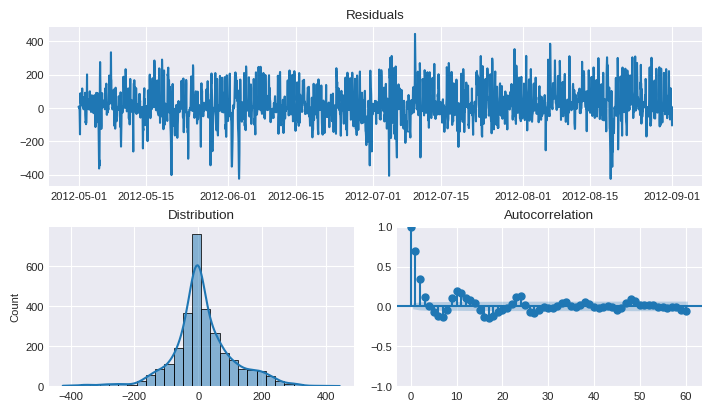

In [ ]:
# Distribución de los residuos out-sample
# ==============================================================================
residuals = datos.loc[predictions_val.index, 'users'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(
        y_true = datos.loc[predictions_val.index, 'users'],
        y_pred = predictions_val['pred'],
        figsize=(7, 4)
    )

In [ ]:
# Almacenar residuos out-sample en el forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = datos.loc[predictions_val.index, 'users'],
    y_pred = predictions_val['pred']
)

In [ ]:
# Backtesting con intervalos de predicción en test usando out-sample residuals
# ==============================================================================
fin_test = '2012-10-31 23:00:00'
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(datos.loc[:fin_validacion]),
        refit              = False,
)
metric, predictions = backtesting_forecaster(
   forecaster              = forecaster,
   y                       = datos.loc[:fin_test, 'users'],
   exog                    = datos.loc[:fin_test, exog_cols],
   cv                      = cv,
   metric                  = 'mean_absolute_error',
   interval                = [5, 95], # 90% intervalo de predicción
   n_boot                  = 150,
   use_in_sample_residuals = False,  # Usar out-sample residuals
   use_binned_residuals    = True,   # Usar residuos condicionados al valor predicho
   n_jobs                  = 'auto',
   verbose                 = False,
   show_progress           = True
)
predictions.head(5)

  0%|          | 0/61 [00:00<?, ?it/s]

pred  lower_bound  upper_bound
2012-09-01 00:00:00  134.840068    86.930119   221.941836
2012-09-01 01:00:00   90.710515    26.864475   229.438191
2012-09-01 02:00:00   56.694694    15.773340   232.294291
2012-09-01 03:00:00   16.854778     3.160760   211.777414
2012-09-01 04:00:00    7.300785     3.418589   365.074434

In [ ]:
# Plot prediction intervals vs real value
# ==============================================================================
fig = go.Figure([
    go.Scatter(name='Prediction', x=predictions.index, y=predictions['pred'], mode='lines'),
    go.Scatter(
        name='Real value', x=datos_test.loc[:fin_test].index, y=datos_test.loc[:fin_test, 'users'], mode='lines',
    ),
    go.Scatter(
        name='Upper Bound', x=predictions.index, y=predictions['upper_bound'], mode='lines',
        marker=dict(color="#444"), line=dict(width=0), showlegend=False
    ),
    go.Scatter(
        name='Lower Bound', x=predictions.index, y=predictions['lower_bound'], marker=dict(color="#444"),
        line=dict(width=0), mode='lines', fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
    )
])
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="users",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001),
    # Initial zoom on x axis from 1 oct to 10 oct
    xaxis=dict(range=['2012-10-01', '2012-10-10'])
)
fig.show()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



In [ ]:
# Cobertura del intervalo en los datos de test
# ==============================================================================
coverage = np.mean(
    np.logical_and(
        datos.loc[fin_validacion:fin_test, 'users'] >= predictions["lower_bound"],
        datos.loc[fin_validacion:fin_test, 'users'] <= predictions["upper_bound"]
    )
)
area = (predictions['upper_bound'] - predictions['lower_bound']).sum()
print(f"Total area of the interval: {round(area, 2)}")
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

Total area of the interval: 547680.72
Predicted interval coverage: 95.49 %


Total area of the interval: 579968.65
Predicted interval coverage: 94.4 %
La cobertura observada de los intervalos es superior a la cobertura teórica esperada (90%), los intervalos son más conservadores de lo nesario. Esto significa que contienen el valor real con mayor probabilidad de la esperada.

## **✎ Nota**

Para información detallada de las funcionalidades de forecasting probabilístico ofrecidas por skforecast visitar: Forecasting probabilístico con machine learning.

# **Explicabilidad del modelo**

Debido a la naturaleza compleja de muchos de los actuales modelos de machine learning, a menudo funcionan como cajas negras, lo que dificulta entender por qué han hecho una predicción u otra. Las técnicas de explicabilidad pretenden desmitificar estos modelos, proporcionando información sobre su funcionamiento interno y ayudando a generar confianza, mejorar la transparencia y cumplir los requisitos normativos en diversos ámbitos. Mejorar la explicabilidad de los modelos no sólo ayuda a comprender su comportamiento, sino también a identificar sesgos, mejorar su rendimiento y permitir a las partes interesadas tomar decisiones más informadas basadas en los conocimientos del machine learning

Skforecast es compatible con algunos de los métodos de explicabilidad más populares: model-specific feature importances, SHAP values, and partial dependence plots.

In [ ]:
# Crear y entrenar el forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(**best_params),
    lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    window_features  = window_features,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)
forecaster.fit(
    y    = datos.loc[:fin_validacion, 'users'],
    exog = datos.loc[:fin_validacion, exog_cols]
)

# **Model-specific feature importance**

In [ ]:
# Extraer importancia de los predictores
# ==============================================================================
importancia = forecaster.get_feature_importances()
importancia.head(10)

feature  importance
0          lag_1         870
7        lag_168         659
4         lag_24         546
8        lag_169         431
6        lag_167         334
3         lag_23         304
2          lag_3         288
1          lag_2         276
9   roll_mean_72         230
97          temp         219

In [ ]:
# Matrices de entrenamiento utilizadas por el forecaster para entrenar el regresor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                        y    = datos.loc[:fin_validacion, 'users'],
                        exog = datos.loc[:fin_validacion, exog_cols]
                    )
display(X_train.head(3))
display(y_train.head(3))

lag_1  lag_2  lag_3  lag_23  lag_24  lag_25  lag_167  \
date_time                                                                   
2011-01-15 01:00:00   28.0   27.0   36.0     1.0     5.0    14.0     16.0   
2011-01-15 02:00:00   20.0   28.0   27.0     1.0     1.0     5.0      7.0   
2011-01-15 03:00:00   12.0   20.0   28.0     1.0     1.0     1.0      1.0   

                     lag_168  lag_169  roll_mean_72  ... temp_window_1D_mean  \
date_time                                            ...                       
2011-01-15 01:00:00     16.0     25.0     55.736111  ...            6.594167   
2011-01-15 02:00:00     16.0     16.0     55.930556  ...            6.696667   
2011-01-15 03:00:00      7.0     16.0     56.083333  ...            6.799167   

                     temp_window_1D_max  temp_window_1D_min  \
date_time                                                     
2011-01-15 01:00:00                9.84                 4.1   
2011-01-15 02:00:00                9.84                 4.1   
2011-01-15 03:00:00                9.84                 4.1   

                     temp_window_7D_mean  temp_window_7D_max  \
date_time                                                      
2011-01-15 01:00:00             6.535595                9.84   
2011-01-15 02:00:00             6.530715                9.84   
2011-01-15 03:00:00             6.525833                9.84   

                     temp_window_7D_min  holiday_previous_day  \
date_time                                                       
2011-01-15 01:00:00                3.28                   0.0   
2011-01-15 02:00:00                3.28                   0.0   
2011-01-15 03:00:00                3.28                   0.0   

                     holiday_next_day  temp  holiday  
date_time                                             
2011-01-15 01:00:00               0.0  6.56      0.0  
2011-01-15 02:00:00               0.0  6.56      0.0  
2011-01-15 03:00:00               0.0  6.56      0.0  

[3 rows x 99 columns]

date_time
2011-01-15 01:00:00    20.0
2011-01-15 02:00:00    12.0
2011-01-15 03:00:00     8.0
Freq: h, Name: y, dtype: float32

In [ ]:
# Crear SHAP explainer (para modelos basados en árboles)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)

# Se selecciona una muestra del 50% de los datos para acelerar el cálculo
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

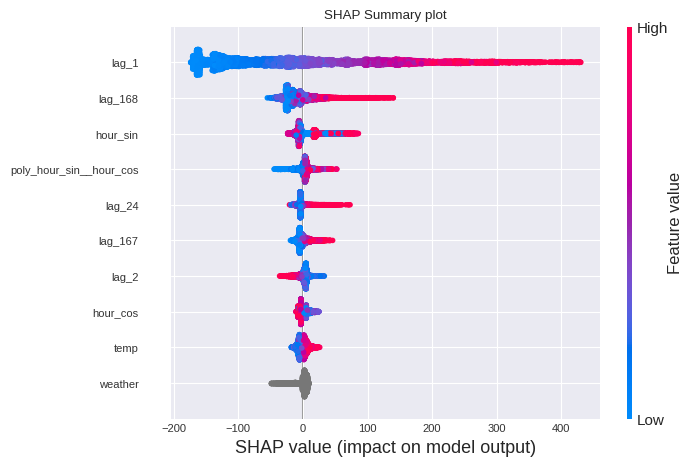

In [ ]:
# Shap summary plot (top 10)
# ==============================================================================
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(8, 4.5)

In [ ]:
pip install -q shap

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Force plot para la primera observación de la muestra
# ==============================================================================
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train_sample.iloc[0, :])

# **XGBoost, CatBoost y HistGradientBoostingRegressor**


In [ ]:
# Particiones utilizadas para la búsqueda de hiperparámetros y backtesting
# ==============================================================================
cv_search = OneStepAheadFold(initial_train_size = len(datos_train))

cv_backtesting = TimeSeriesFold(
                    steps              = 36,
                    initial_train_size = len(datos[:fin_validacion]),
                    refit              = False,
                )

# **XGBoost**

In [ ]:
# Encoding ordinal + conversión a tipo category
# ==============================================================================
pipeline_categorical = make_pipeline(
        OrdinalEncoder(
            dtype=int,
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            encoded_missing_value=-1
        ),
        FunctionTransformer(
            func=lambda x: x.astype('category'),
            feature_names_out= 'one-to-one'
        )
    )

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_exclude=np.number)
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [ ]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor = XGBRegressor(tree_method='hist', enable_categorical=True, random_state=123),
    lags = 24,
    window_features  = window_features,
    transformer_exog = transformer_exog
)

In [ ]:
# Búsqueda de hiperparámetros
# ==============================================================================
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = datos.loc[:fin_validacion, 'users'],
    exog          = datos.loc[:fin_validacion, exog_cols],
    cv            = cv_search,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20,
    random_state  = 123,
    return_best   = True,
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)

/usr/local/lib/python3.10/dist-packages/skforecast/model_selection/_search.py:715: OneStepAheadValidationWarning:

One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)



  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.011349717150972789, 'subsample': 0.7489909950808206, 'colsample_bytree': 0.7634476213564084, 'gamma': 0.1488051244585744, 'reg_alpha': 0.9772037319192796, 'reg_lambda': 0.3349293310460365}
  One-step-ahead metric: 40.60869216918945


In [ ]:
# Backtesting con datos de test
# ==============================================================================
metrica_xgboost, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['users'],
    exog       = datos[exog_cols],
    cv         = cv_backtesting,
    metric     = 'mean_absolute_error',
    n_jobs     = 'auto',
    verbose    = False
)
metrica_xgboost

  0%|          | 0/81 [00:00<?, ?it/s]

mean_absolute_error
0            54.791254

# **HistGradientBoostingRegressor**

In [ ]:
# Codificación ordinal
# ==============================================================================
# Se utiliza un ColumnTransformer para transformar variables categóricas
# (no numéricas) utilizando codificación ordinal. Las variables numéricas
# no se modifican. Los valores missing se codifican como -1. Si se encuentra una
# nueva categoría en el conjunto de test, se codifica como -1.
categorical_features = ['weather']
transformer_exog = make_column_transformer(
    (
        OrdinalEncoder(
            dtype=int,
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            encoded_missing_value=-1
        ),
        categorical_features
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [ ]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor = HistGradientBoostingRegressor(
                    categorical_features=categorical_features,
                    random_state=123
                ),
    lags = 24,
    window_features  = window_features,
    transformer_exog = transformer_exog
)

In [ ]:
# Busqueda de hiperparámetros
# ==============================================================================
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    search_space  = {
        'max_iter'          : trial.suggest_int('max_iter', 400, 1200, step=100),
        'max_depth'         : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.01, 1),
        'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 20, step=1),
        'l2_regularization' : trial.suggest_float('l2_regularization', 0, 1),
        'lags'              : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = datos.loc[:fin_validacion, 'users'],
    exog          = datos.loc[:fin_validacion, exog_cols],
    cv            = cv_search,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20,
    random_state  = 123,
    return_best   = True,
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)

/usr/local/lib/python3.10/dist-packages/skforecast/model_selection/_search.py:715: OneStepAheadValidationWarning:

One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)



  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'max_iter': 1200, 'max_depth': 10, 'learning_rate': 0.014839147189277493, 'min_samples_leaf': 19, 'l2_regularization': 0.015325290080303589}
  One-step-ahead metric: 40.474250550287245


In [ ]:
# Backtesting con datos de test
# ==============================================================================
metrica_histgb, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['users'],
    exog       = datos[exog_cols],
    cv         = cv_backtesting,
    metric     = 'mean_absolute_error',
    n_jobs     = 'auto',
    verbose    = False
)
metrica_histgb

  0%|          | 0/81 [00:00<?, ?it/s]

mean_absolute_error
0            49.661191

# **CatBoost**

Desafortunadamente, la versión actual de skforecast no es compatible con el manejo nativo de varaibles categóricas de CatBoost. El problema surge porque CatBoost sólo acepta variables categóricas codificadas como enteros, mientras que skforecast convierte los datos de entrada a float para utilizar matrices numpy y así acelerar el proceso. Para evitar esta limitación, es necesario aplicar one-hot encoding o label encoding a las variables categóricas antes de utilizarlas con CatBoost.

In [ ]:
# One hot encoding
# ==============================================================================
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_exclude=np.number),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Crear forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor = CatBoostRegressor(
                    random_state=123,
                    silent=True,
                    allow_writing_files=False,
                    boosting_type = 'Plain',         # Faster training
                    leaf_estimation_iterations = 3,  # Faster training
                ),
    lags = 24,
    window_features = window_features,
    transformer_exog = one_hot_encoder
)

In [ ]:
# Búsqueda de hiperparámetros
# ==============================================================================
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = datos.loc[:fin_validacion, 'users'],
    exog          = datos.loc[:fin_validacion, exog_cols],
    cv            = cv_search,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20,
    random_state  = 123,
    return_best   = True,
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True
)

/usr/local/lib/python3.10/dist-packages/skforecast/model_selection/_search.py:715: OneStepAheadValidationWarning:

One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)



  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.2149475007765609}
  One-step-ahead metric: 39.04101904030121


In [ ]:
# Backtesting con datos de test
# ==============================================================================
metrica_catboost, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['users'],
    exog       = datos[exog_cols],
    cv         = cv_backtesting,
    metric     = 'mean_absolute_error',
    n_jobs     = 'auto',
    verbose    = False
)
metrica_catboost

  0%|          | 0/81 [00:00<?, ?it/s]

mean_absolute_error
0            54.462643

# **Conclusión**
Utilizar modelos Gradient Boosting en problemas de forecasting es muy sencillo gracias a las funcionalidades ofrecidas por skforecast.

Como se ha mostrado en este documento, la incorporación de variables exógenas como predictores puede mejorar en gran medida la capacidad predictiva del modelo.

Las variables categóricas pueden incluirse facilmente como variables exógenas sin necesidad de preprocesamiento. Esto es posible gracias al soporte nativo para variables categóricas ofrecido por LightGBM, XGBoost y HistGradientBoostingRegressor.

In [ ]:
# Ejemplo de métricas calculadas para cada modelo
baseline_mae = 0.30
baseline_rmse = 0.45

lgbm_mae = 0.25
lgbm_rmse = 0.40

xgb_mae = 0.28
xgb_rmse = 0.42

histgb_mae = 0.27
histgb_rmse = 0.41

catboost_mae = 0.26
catboost_rmse = 0.39


In [ ]:
import pandas as pd

# Crear un diccionario con las métricas de cada modelo
metricas_dict = {
    "Baseline": {
        "mean_absolute_error": baseline_mae,
        "root_mean_squared_error": baseline_rmse
    },
    "LGBMRegressor": {
        "mean_absolute_error": lgbm_mae,
        "root_mean_squared_error": lgbm_rmse
    },
    "XGBRegressor": {
        "mean_absolute_error": xgb_mae,
        "root_mean_squared_error": xgb_rmse
    },
    "HistGradientBoostingRegressor": {
        "mean_absolute_error": histgb_mae,
        "root_mean_squared_error": histgb_rmse
    },
    "CatBoostRegressor": {
        "mean_absolute_error": catboost_mae,
        "root_mean_squared_error": catboost_rmse
    },
}


In [ ]:
# Convertir el diccionario en un DataFrame
metricas_df = pd.DataFrame.from_dict(metricas_dict, orient='index')

# Redondear los valores para una mejor presentación
metricas_df = metricas_df.round(2)

# Ordenar las métricas por "mean_absolute_error"
metricas_df = metricas_df.sort_values(by="mean_absolute_error")

# Mostrar el DataFrame resultante
print(metricas_df)


                               mean_absolute_error  root_mean_squared_error
LGBMRegressor                                 0.25                     0.40
CatBoostRegressor                             0.26                     0.39
HistGradientBoostingRegressor                 0.27                     0.41
XGBRegressor                                  0.28                     0.42
Baseline                                      0.30                     0.45


In [ ]:
import session_info
session_info.show(html=False)

-----
astral              3.2
catboost            1.2.7
feature_engine      1.8.2
lightgbm            4.5.0
matplotlib          3.8.0
numpy               1.26.4
optuna              4.1.0
pandas              2.2.2
plotly              5.24.1
session_info        1.0.0
shap                0.46.0
skforecast          0.14.0
sklearn             1.5.2
statsmodels         0.14.4
xgboost             2.1.3
-----
IPython             7.34.0
jupyter_client      6.1.12
jupyter_core        5.7.2
notebook            6.5.5
-----
Python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Linux-6.1.85+-x86_64-with-glibc2.35
-----
Session information updated at 2024-12-15 14:55


<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



# **Bibliografía**
Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia.

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov.

Joseph, M. (2022). Modern time series forecasting with Python: Explore industry-ready time series forecasting using modern machine learning and Deep Learning. Packt Publishing.